# Dvostruko njihalo


## Uvod:
Dvostruko njihalo je sustav koji se satstoji od matematičkog njihala te još jednog matematičkog njihala obješeno na prvo. Takav sustav je jedan od najjednostavnijih primjera koji vode na kaotično gibanje tj., proizvoljno male promjene u početnim uvjetima vode na jako razčičita ponašanja. U sljedečoj čeliji imamo schematski prikaz dvostrukog njihala. 

In [1]:
from IPython import *         # IPython
from IPython.display import * # Prikaz objekata

## Schematski prikaz dvostrukog njihala

try:
    display(Image(filename = 'doublePend.png', width = 450))
except FileNotFoundError:
    display(Image(url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Double-Pendulum.svg/170px-Double-Pendulum.svg.png', width = 450))


 Dvostruko njihalo najlakše je opisati riješavanjem Euler-Lagranegovih jednadžbi. To su jednadžbe kojima nalazimo stacionarne točke funkcionala $S(q) = \int_{a}^{b} L(\vec{q},\dot{\vec{q}},t) dt$, pri ćemu je $\vec{q} = (q_1,q_2,...)$ vektor generaliziranih koordinata, $\vec{\dot{q}} = (\dot{q_1},\dot{q_2},...)$ vektor generaliziranih brzina, a $L$ funkcija realne varijable sa neprekidnim prvim parcijalnim derivacijama.

Euler-Lagrangeove jednadžbe su tada dane izrazom: 

$L_x(t,q(t),\dot{q}(t))-\frac{\mathrm{d}}{\mathrm{d}t}L_v(t,q(t),\dot{q}(t)) = 0$, 

pri ćemu subskripti označuju parcijalne derivacije po generaliziranom položaju odnosno brzini.

U našem slučaju generalizirane koordinate su $\theta_1 $ i $  \theta_2$ kutovi otklona, a generalizirane brzine su $\dot{\theta_1}$ = $\omega_1$ i $\dot{\theta_2}$ = $\omega_2$ kružne frekvencije. 
Lagrangian je izveden ručno kao razlika kinetičke i potencijalne energije.
Kao pomoć korištena je ova stranica http://scienceworld.wolfram.com/physics/DoublePendulum.html .
Korištene su polarne koordinate umjesto kartezijevih zbog toga što bi se u kartezijevim trebala koristiti netrivijalna funkcija ograničenja (l1, l2 = konst) dok se to prirodno nameće u polarnim koordinatama
Razlog izbjegavanja fiksnog uporišta kod koordinate $\theta_2$ je što bi kao i u prethodnom primjeru trebali tražiti funkciju ograničenja dok se ovako prirodno nameće.

# Uvođenje paketa:

Dobar dio ovog problema riješavati ćemo koristeći Sympy paket, Sympy je paket namjenjen simboličkom programiranju, s naglaskom na pojednostavljivanje problema iz matematike, te matematičke fizike. Za numeriku korišten je SciPy, kao standarni paket za znastveno računanje, a za operacije s vektorima i matricama naravno numpy. Osim toga korištene su brojne funkcionalnosti iz paketa matplotlib za vizualizaciju podataka. U čeliji ispod ćemo uvesti sve potrebne pakete:



In [2]:
from sympy.physics.mechanics import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sympy import *
from sympy.physics.mechanics import init_vprinting
import numpy as np
import mpmath as mp
from mpl_toolkits.mplot3d import Axes3D
from time import time
mechanics_printing()
from matplotlib.animation import FuncAnimation
import random as rnd
plt.style.use('seaborn-pastel')
%matplotlib notebook

## Dinamičke varijable

Sada ćemo definirati potrebne varijalbe, osim običnih varijabli koje definiramo funkcijom symbols() postoje takozvane dinamičke varijeble (dynamicsymbols()), za razliku od običnih varijabla one su zapravo vremenske funkcije. Primjetimo kako je jednostavno definirati brzine i akceleracije putem funkcije dynamicsymbols, drugi argument funkcije nam govori o kojoj derivaciji varijable je riječ. U donjoj čeliji uveli smo potrebne varijable.

In [3]:
q1, q2 = dynamicsymbols('theta_1 theta_2')
dq1, dq2 = dynamicsymbols('theta_1 theta_2', 1)
ddq1, ddq2 = dynamicsymbols('theta_1 theta_2', 2)
m1, m2 = symbols('m_1 m_2')
l1, l2 = symbols('theta_1 theta_2')
g = symbols('g')
L = symbols('L')

Nadalje uvodimo izračunati Lagrangian i vidimo kako lagano dobivamo sređeni ispis u LateXu:

In [4]:
L = 1/2*(m1+m2)*l1**2*dq1**2 + 1/2*m2*l2**2*dq2**2 + m2*l1*l2*dq1*dq2*cos(q1-q2) + (m1+m2)*g*l1*cos(q1) +m2*g*l2*cos(q2) 




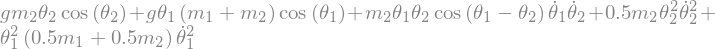

In [5]:
L

# Labmdifikacija:
Naime, kako treba raditi s izrazima u kojima se pojavljuju prve i druge derivacije, defaultni zapis koji koristi puni raspis diferencijalnog operatora d/dt vrlo brzo postaje nepregledan i neelegantan. Stoga je omogućen prikaz vremenskih derivacija preko Newtonove notacije.
Kako bismo izbjegli potrebu za ručnim prepisivanjem i kopiranjem simboličkih izraza, potrebno je automatizirati čitav postupak. Pri tome smo se koristili lambdifikacijom.

In [6]:
def dummify_undefined_functions(expr):
    mapping = {}    

    for der in expr.atoms(Derivative):
        f_name = der.expr.func.__name__
        var_names = [var.name for var in der.variables]
        name = "d%s_d%s" % (f_name, 'd'.join(var_names))
        mapping[der] = Symbol(name)

    from sympy.core.function import AppliedUndef
    for f in expr.atoms(AppliedUndef):
        f_name = f.func.__name__
        mapping[f] = Symbol(f_name)

    return expr.subs(mapping)

## Objektni pristup i numerika

U sljedećoj čeliji definirat ćemo klasu DoublePendelum koja će sadržavati sve bitne podatke o sustavu: duljine niti, mase niti, gravitacijsko ubrzanje te početne uvjete. Ona će biti u mogućnosti odrediti Lagrangian sistema, Euler-Lagrangeove jednadžbe, ukupnu energiju sistema, funkcionalnu ovisnost akceleracije o kutu i kutnim brzinama. To ćemo kasnije koristiti u funkciji pSolveOde, ona riješava sustav diferencijalnih jednadžbi drugog reda, tako da ga razveze na sustav diferencijalnih jednadžbi prvog reda uz supsituciju: $\omega = \dot{\theta}$. Takav sustav lambdificiramo i numerički integriramo funkcijom odeint. Kao rezultat imamo matricu pomoću koje možemo vizualizirati podatke. Također je bitno istaknuti najbitniju funkcionalnost naše klase, a to je da se može updateati. To će nam biti od koristi kada budemo radili animaciju dvostrukog njihala. Najveći dio projekta napravljen je koristeći http://docs.sympy.org
Tamo se može pronači kako se koristiti dinamičkim simbolima te kako postaviti Euler-Lagrangeove jednadžbe i iz njih izvuči korisne podatke.

In [7]:
def getLagrangian(pend): ###Funkcija koja vraća lagrangian koji je ručno dobiven
        (l1, l2, m1, m2, g) = pend.paramts
        L = ( 1/2*(m1+m2)*l1**2*dq1**2 + 1/2*m2*l2**2*dq2**2 + m2*l1*l2*dq1*dq2*cos(q1-q2) +
              (m1+m2)*g*l1*cos(q1) + m2*g*l2*cos(q2) )
        return L

def lagrangianMethod(pend): ### Ovo je međukorak iz kojeg ćemo izvući potrebne jednadžbe
        return LagrangesMethod(getLagrangian(pend), [pend.q1, pend.q2]) 

def getELEquations(pend): ### ovdje dobivamo EL jednadžbe
        return pend.lagrangianM.form_lagranges_equations() 
    
def getAcceleration(pend): ### ovdje dobivamo funkcionalne ovisnosti drugih derivacija kutova prvim i nultim
        return solve(pend.ELeqs, [pend.ddq1,pend.ddq2])
    
def pSolveOde(pend, N, T):
        """time smo problem sveli na na sustav dviju diferencjialnih jednadžbi drugog reda. Sustav ćemo 
        prvo razvezati na sustav jednadžbi prvog reda, zatim lambdificirati, a potom 
        integrirati funkcijom odeint"""
        params = [dummify_undefined_functions(x) for x in [pend.q1, pend.dq1, pend.q2, pend.dq2]]
        expr1 = dummify_undefined_functions(pend.acceleration[ddq1])
        expr2 = dummify_undefined_functions(pend.acceleration[ddq2])
        f1 = lambdify(params, expr1)
        f2 = lambdify(params, expr2) ## lambdifikacija
        ts = np.linspace(0,T,N)
        if N == 1: ### ovo se možda čini redudandno, ali je od velike važnosti za  funkciju update
            ts = [0,T]
        F = odeint(lambda y,t: [y[1], f1(y[0],y[1],y[2],y[3]), y[3],  
                                f2(y[0],y[1],y[2],y[3])], pend.state,ts) #Scipy funkcija koja nam rješava ODJ
        return F
    
"""Razlog zašto gornje funkcije nismo učinili metodama je efikasnost i preglednost, ovako 
jednom kada se objekt napravi izračunaju se potrebni parametri i dobiju funkcijske ovisnosti
kojima kasnije možemo baratati, a ako bismo to sve utrpali u __init__ bilo bi jako nepregledno"""    

class DoublePendulum:
    """Klasa koja nam stvara objekt dvosktruko njihalo njihalo možemo inicijalizirati nizom parametara [theta1, omega1
    theta2, omega2] koji su opisani u gornjem tekstu. Otklone zadajemu u stupnjevima, a kružne brzine u 
    stupnjevima po sekundi.
    """
    def __init__(self,
                 init_state = [120, 0, -20, 0],
                 l1=1.0,  # duljina njihala 1 u metrima
                 l2=1.0,  # duljina njihala 2 u metrima
                 m1=1.0,  # masa njihala 1 u kg
                 m2=1.0,  # masa njihala 2 2 u kg
                 g=9.8,  # gravitacijsko ubrzanje m/s^2
                 origin=(0, 0)): 
        self.init_state = np.asarray(init_state, dtype='float')
        self.paramts = (l1, l2, m1, m2, g)
        self.origin = origin
        self.time_elapsed = 0
        self.state = self.init_state * np.pi / 180.
        self.q1, self.q2 = dynamicsymbols('theta_1 theta_2')
        self.dq1, self.dq2 = dynamicsymbols('theta_1 theta_2', 1)
        self.ddq1, self.ddq2 = dynamicsymbols('theta_1 theta_2', 2)
        self.Lagrangian = getLagrangian(self)
        self.lagrangianM = lagrangianMethod(self)
        self.ELeqs = getELEquations(self)
        self.acceleration = getAcceleration(self)
        
    def getPosition(self):
        """Ova metoda nam vraća poziciju masa u kartezijevom koordinatnom sustavu"""
        (L1, L2, M1, M2, G) = self.paramts

        x = np.cumsum([self.origin[0],
                       L1 * np.sin(self.state[0]),
                       L2 * np.sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                       -L1 * np.cos(self.state[0]),
                       -L2 * np.cos(self.state[2])])
        return (x, y)
        

    
    def getEnergy(self):
        """Ova metoda nam vraća energiju sustava, pomoću nje možemo
        lako provjeriti zakon sačuvanja energije
        """
        q1,dq1,q2,dq2 = self.state[0], self.state[1], self.state[2], self.state[3]
        (l1, l2, m1, m2, g) = self.paramts
        E = ( +1/2*(m1+m2)*l1**2*dq1**2 + 1/2*m2*l2**2*dq2**2 + m2*l1*l2*dq1*dq2*cos(q1-q2) -
              (m1+m2)*g*l1*cos(q1) - m2*g*l2*cos(q2) )
        return E
    

    
    def update(self, newState, dt):
        """Ova metoda nam updatea položaj"""
        self.state = newState
        self.time_elapsed += dt

## Igranje klasom
Idemo se malo igrati našom klasom i vidjeti što sve ona može. Za početak ćemo stvoriti jedan objekt pendulum te utvrditi njegov lagrangian, energiju, EL jednadžbe te funkcionalne ovisnosti akceleracija.

In [8]:
rndTh1 = (2*rnd.random() - 1) * 180 #nasumican kut1
rndTh2 = (2*np.random.uniform(-1,1, (1,1)) - 1) * 180 #nasumican kut2 dobiven drugim nacinom
rndOm1 = rnd.uniform(-30,30) #nasumicna brzina 1
rndOm2 = rnd.uniform(-1,1)*rnd.gauss(30,5) #nasumicna brzina 1
#generiramo njihalo s nasumičnim početnim uvjetima

pendulum = DoublePendulum([rndTh1,rndOm1,rndTh2,rndOm2], l1 = 2, l2 = 3, m1 = 0.5, m2 = 4)
print(pendulum.init_state) #ispisujemo dobivene početne uvjete

[ 152.94743982   16.07480836 -369.99320273   17.00147762]


In [9]:
pendulum.Lagrangian 

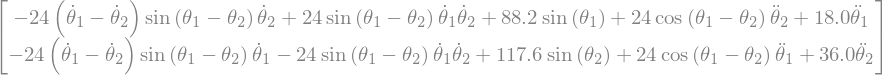

In [10]:
pendulum.ELeqs

In [11]:
pendulum.getEnergy()

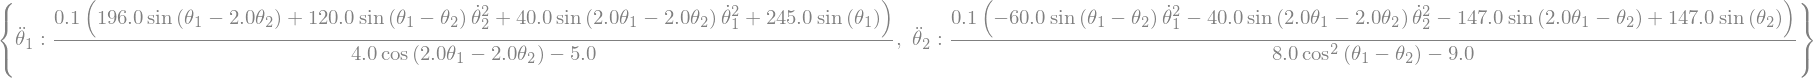

In [12]:
pendulum.acceleration

## Vizualizacija
Sada ćemo definirati funkcije koje će nam crtati razne ovisnoti. Za početak preklopljene kutove u vremenu. 

In [13]:
def crtajPreklopljeneKutove(F,N,T):
    ts = np.linspace(0,T,N)
    fig, ax = plt.subplots(figsize=[7,3])
    ax.plot(ts, F[:,0], label='$\Theta_1$(t)')
    ax.plot(ts, F[:,2], label='$\Theta_2$(t)')
    ax.legend()

In [14]:
F = pSolveOde(pendulum, 50, 5)

<IPython.core.display.Javascript object>


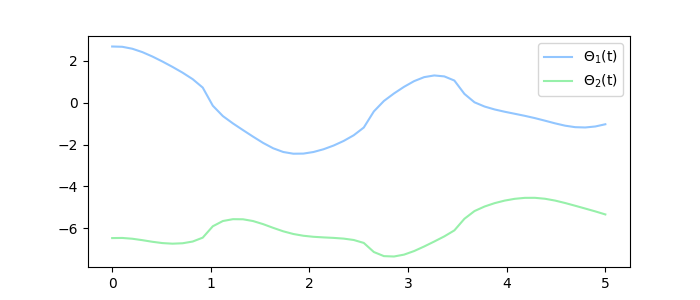

In [15]:
crtajPreklopljeneKutove(F, 50,5)

Nadalje, preklopljene kutne brzine u vremenu.

In [16]:
def crtajPreklopljeneBrzine(F,N,T):
    ts = np.linspace(0,T,N)
    fig2, ax2 = plt.subplots(figsize=[7,3])
    ax2.plot(ts, F[:,1], label='$\omega_1$(t)')
    ax2.plot(ts, F[:,3], label='$\omega_2$(t)')
    ax2.legend()

<IPython.core.display.Javascript object>


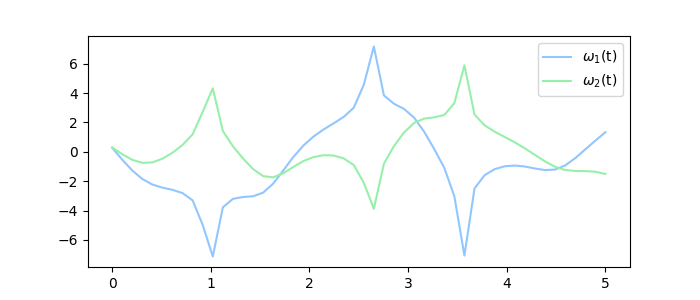

In [17]:
crtajPreklopljeneBrzine(F,50,5)

Nadalje može nas interesirat ovisnost $\theta_2$ o $\theta_1$, to je puno efektnije u obliku 3D plota pa ćemo to i učiniti: 

In [18]:
def crtajOvisnostKuteva(F,T,N):
    fig3 = plt.figure()
    ax3 = plt.axes(projection="3d")
    z_line = np.linspace(0, T, N)
    x_line = F[:,0]
    y_line = F[:,2]
    ax3.plot3D(x_line, y_line, z_line, 'red', label='($\Theta_1 - \Theta2)(t)$')
    ax3.legend()

<IPython.core.display.Javascript object>


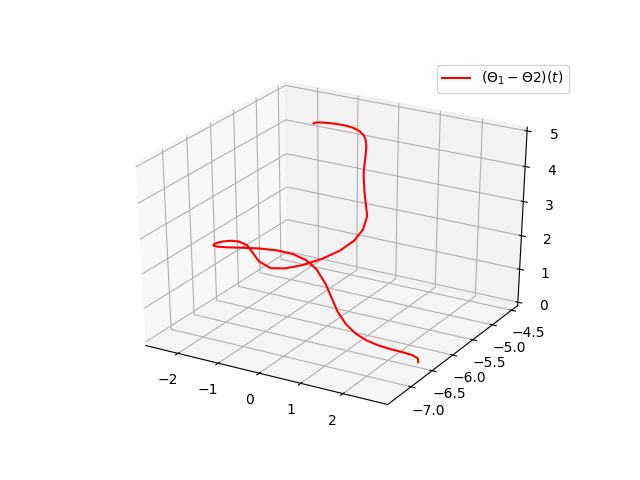

In [19]:
crtajOvisnostKuteva(F,5,50)

Istu stvar ćemo vapraviti i za $\omega$.

In [20]:
def crtajOvisnostBrzina(F,T,N):
    fig3 = plt.figure()
    ax3 = plt.axes(projection="3d")
    z_line = np.linspace(0, T, N)
    x_line = F[:,1]
    y_line = F[:,3]
    ax3.plot3D(x_line, y_line, z_line, 'green', label='($\omega_1 - \omega_2)(t)$')
    ax3.legend()

<IPython.core.display.Javascript object>


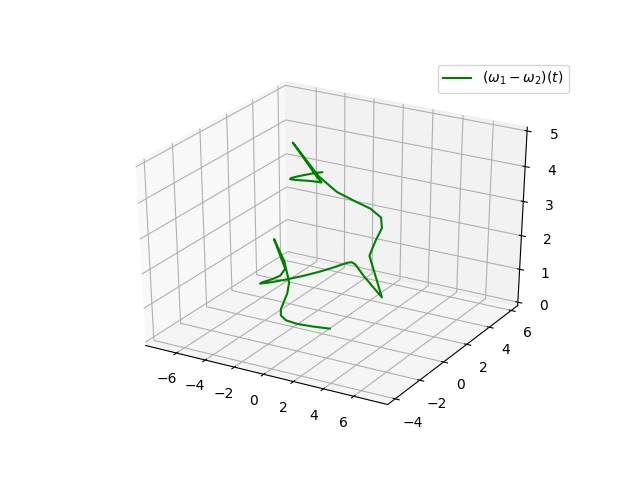

In [21]:
crtajOvisnostBrzina(F,5,50)

Sada ćemo generirati animaciju dvostrukog njihala, animacija će sadržavati protečeno vrijeme te ukupnu energiju sustava.  

<IPython.core.display.Javascript object>


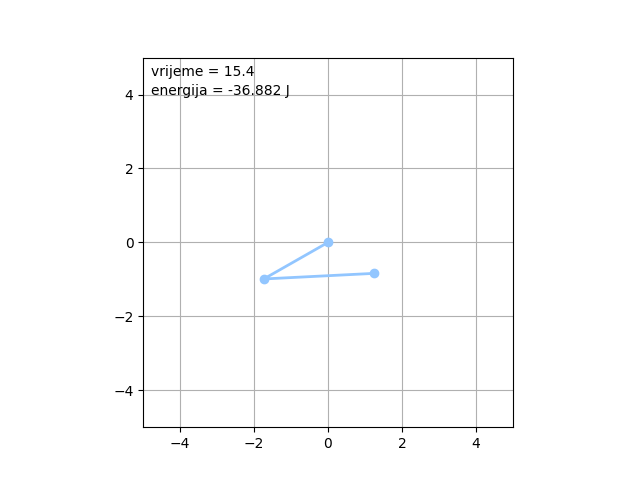

In [22]:
"""u ovom dijelu ćemo generirati animaciju dvostrukog njihala, koji će nam prikazivati i energiju i protečeno
vrijeme, primjetimo da je energija konstanta to je uvijek dobar znak"""

dt = 1./30 # 30 fps


fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-pendulum.paramts[0]-pendulum.paramts[1], 
                           +pendulum.paramts[0]+pendulum.paramts[1]), 
                     ylim=(-pendulum.paramts[0]-pendulum.paramts[1], 
                           +pendulum.paramts[0]+pendulum.paramts[1]))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """inicijalizacija animacije"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    """provodimo korak animacije"""
    global pendulum, dt
    pendulum.update(pSolveOde(pendulum,1,0.1)[1],dt)
    line.set_data(*pendulum.getPosition())
    time_text.set_text('vrijeme = %.1f' % pendulum.time_elapsed)
    energy_text.set_text('energija = %.3f J' % pendulum.getEnergy())
    return line, time_text, energy_text


t0 = time()
animate(0)
t1 = time()
interval =  1000*dt - (t1 - t0)

ani = FuncAnimation(fig, animate, frames=300,
                              interval=interval, blit=True, init_func=init)


## Reference:

https://en.wikipedia.org/wiki/Euler%E2%80%93Lagrange_equation

http://scienceworld.wolfram.com/physics/DoublePendulum.html 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

https://docs.python.org/3/tutorial/classes.html

https://towardsdatascience.com/an-easy-introduction-to-3d-plotting-with-matplotlib-801561999725

https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c

https://docs.sympy.org/latest/index.html

https://stackoverflow.com/questions/29920641/lambdify-a-sympy-expression-that-contains-a-derivative-of-undefinedfunction?rq=1